# HGPS


## Introduction

The **H.E.S.S. Galactic Plane Survey (HGPS)** is the first deep and wide survey of the Milky Way in TeV gamma-rays.

In April 2018, a paper on the HGPS was published, and survey maps and a source catalog on the HGPS in FITS format released.

More information, and the HGPS data for download in FITS format is available here:
https://www.mpi-hd.mpg.de/hfm/HESS/hgps

**Please read the Appendix A of the paper to learn about the caveats to using the HGPS data. Especially note that the HGPS survey maps are correlated and thus no detailed source morphology analysis is possible, and also note the caveats concerning spectral models and spectral flux points.**

## Notebook Overview

This is a Jupyter notebook that illustrates how to work with the HGPS data from Python.

You will learn how to access the HGPS images as well as the HGPS catalog and other tabular data using Astropy and Gammapy.

* In the first part we will only use Astropy to do some basic things.
* Then in the second part we'll use Gammapy to do some things that are a little more advanced.

The notebook is pretty long: feel free to skip ahead to a section of your choice after executing the cells in the "Setup" and "Download data" sections below.

Note that there are other tools to work with FITS data that we don't explain here. Specifically [DS9](http://ds9.si.edu/) and [Aladin](http://aladin.u-strasbg.fr/) are good FITS image viewers, and [TOPCAT](http://www.star.bris.ac.uk/~mbt/topcat/) is great for FITS tables. Astropy and Gammapy are just one way to work with the HGPS data; any tool that can access FITS data can be used.

## Packages

We will be using the following Python packages

* [astropy](http://docs.astropy.org/)
* [gammapy](http://docs.gammapy.org/)
* [matplotlib](https://matplotlib.org/) for plotting

Under the hood all of those packages use Numpy arrays to store and work with data.

More specifically, we will use the following functions and classes:

* From [astropy](http://docs.astropy.org/), we will use [astropy.io.fits](http://docs.astropy.org/en/stable/io/fits/index.html) to read the FITS data, [astropy.table.Table](http://docs.astropy.org/en/stable/table/index.html) to work with the tables, but also [astropy.coordinates.SkyCoord](http://docs.astropy.org/en/stable/coordinates/index.html) and [astropy.wcs.WCS](http://docs.astropy.org/en/stable/wcs/index.html) to work with sky and pixel coordinates and [astropy.units.Quantity](http://docs.astropy.org/en/stable/units/index.html) to work with quantities.

* From [gammapy](http://docs.gammapy.org/), we will use [gammapy.image.SkyImage](http://docs.gammapy.org/dev/api/gammapy.image.SkyImage.html) to work with the HGPS sky maps, and [gammapy.catalog.SourceCatalogHGPS](http://docs.gammapy.org/dev/api/gammapy.catalog.SourceCatalogHGPS.html) and [gammapy.catalog.SourceCatalogObjectHGPS](http://docs.gammapy.org/dev/api/gammapy.catalog.SourceCatalogObjectHGPS.html) to work with the HGPS catalog data, especially the HGPS spectral data using [gammapy.spectrum.models.SpectralModel](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.SpectralModel.html) and [gammapy.spectrum.FluxPoints](http://docs.gammapy.org/dev/api/gammapy.spectrum.FluxPoints.html) objects.

* [matplotlib](https://matplotlib.org/) for all plotting. For sky image plotting, we will use matplotlib via [astropy.visualization](http://docs.astropy.org/en/stable/visualization/index.html) and [gammapy.image.SkyImage.plot](http://docs.gammapy.org/dev/api/gammapy.image.SkyImage.html#gammapy.image.SkyImage.plot).

If you're not familiar with Python, Numpy, Astropy, Gammapy or matplotlib yet, use the tutorial introductions as explained [here](http://docs.gammapy.org/dev/tutorials.html), as well as the links to the documentation that we just mentioned.

## Setup

We start by importing everything we will use in this notebook, and configuring the notebook to show plots inline.

If you get an error here, you probably have to install the missing package and re-start the notebook.

If you don't get an error, just go ahead, no nead to read the import code and text in this section.

In [1]:
import numpy as np

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS

import astropy
print(astropy.__version__)

3.1.dev21648


In [3]:
from gammapy.image import SkyImage
from gammapy.catalog import SourceCatalogHGPS

import gammapy
print(gammapy.__version__)

0.8.dev5699


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib
print(matplotlib.__version__)

2.2.2


In [5]:
# This will work on Python 3, but fail on Python 2
from pathlib import Path
from urllib.request import urlretrieve

If you're still using Python 2, please update to Python 3!

Also, it's time to start using [JupyterLab](http://jupyterlab.readthedocs.io/)
(which is Python 3 only, Jupyter dropped Python 2 support in 2017).

But OK, to be honest, actually everything here will work on Python 2,
we avoided the use of Python 3 only features for now.
You just have to import `Path` and `urlretrieve` from here instead:

In [6]:
# This will work on Python 2 as well as Python 3
# from gammapy.extern.six.moves.urllib.request import urlretrieve
# from gammapy.extern.pathlib import Path

## Download Data

First, you need to download the HGPS FITS data from https://www.mpi-hd.mpg.de/hfm/HESS/hgps .

If you haven't already, you can use the following commands to download the files to your local working directory.

You don't have to read the code in the next cell; that's just how to downlaod files from Python.
You could also download the files with your web browser, or from the command line e.g. with curl:

    mkdir hgps_data
    cd hgps_data
    curl -O https://www.mpi-hd.mpg.de/hfm/HESS/hgps/data/hgps_catalog_v1.fits.gz
    curl -O https://www.mpi-hd.mpg.de/hfm/HESS/hgps/data/hgps_map_significance_0.1deg_v1.fits.gz

**The rest of this notebook assumes that you have the data files at ``hgps_data_path``.**

In [7]:
# Download HGPS data used in this tutorial to a folder of your choice
# The default `hgps_data` used here is a sub-folder in your current
# working directory (where you started the notebook)
hgps_data_path = Path('hgps_data')

# In this notebook we will only be working with the following files
# so we only download what is needed.
hgps_filenames = [
    'hgps_catalog_v1.fits.gz',
    'hgps_map_significance_0.1deg_v1.fits.gz',
]

In [8]:
def hgps_data_download():
    base_url = 'https://www.mpi-hd.mpg.de/hfm/HESS/hgps/data/'    
    for filename in hgps_filenames:
        url = base_url + filename
        path = hgps_data_path / filename
        if path.exists():
            print('Already downloaded: {}'.format(path))
        else:
            print('Downloading {} to {}'.format(url, path))
            urlretrieve(url, str(path))

hgps_data_path.mkdir(parents=True, exist_ok=True)
hgps_data_download()

print('\n\nFiles at {} :\n'.format(hgps_data_path.absolute()))
for path in hgps_data_path.iterdir():
    print(path)

Already downloaded: hgps_data/hgps_catalog_v1.fits.gz
Already downloaded: hgps_data/hgps_map_significance_0.1deg_v1.fits.gz


Files at /Users/deil/code/gammapy-extra/notebooks/hgps_data :

hgps_data/hgps_map_significance_0.1deg_v1.fits.gz
hgps_data/hgps_my_format.csv
hgps_data/hgps_my_format.reg
hgps_data/hgps_catalog_v1.fits.gz


## Catalog with Astropy

### FITS file content

Let's start by just opening up `hgps_catalog_v1.fits.gz` and looking at the content.

Note that ``astropy.io.fits.open`` doesn't work with `Path` objects yet,
so you have to call `str(path)` and pass a string.

In [9]:
path = hgps_data_path / 'hgps_catalog_v1.fits.gz'
hdu_list = fits.open(str(path))

In [10]:
hdu_list.info()

Filename: hgps_data/hgps_catalog_v1.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  HGPS_SOURCES    1 BinTableHDU    327   78R x 78C   [16A, 6A, 10A, 20A, 7A, E, E, E, E, E, E, E, E, K, 18A, 103A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, K, 40E, 40E, 40E, 40E, 40E, 40E, 40E, 40B]   
  2  HGPS_GAUSS_COMPONENTS    1 BinTableHDU     87   98R x 13C   [9A, 16A, 15A, E, E, E, E, E, E, E, E, E, E]   
  3  HGPS_ASSOCIATIONS    1 BinTableHDU     39   223R x 4C   [16A, 5A, 21A, E]   
  4  HGPS_IDENTIFICATIONS    1 BinTableHDU     53   31R x 9C   [16A, 17A, 9A, 11A, 21A, 21A, E, E, E]   
  5  HGPS_LARGE_SCALE_COMPONENT    1 BinTableHDU     55   50R x 7C   [E, E, E, E, E, E, E]   
  6  SNRCAT        1 BinTableHDU     56   282R x 7C   [11A, E, E, 29A, E, E, E]   


There are six tables. Each table and column is described in detail in the HGPS paper.

### Access table data

We could work with the `astropy.io.fits.HDUList` and `astropy.io.fits.BinTable` objects.
However, in Astropy a nicer class to work with tables has been developed: `astropy.table.Table`.

We will only be using `Table`, so let's convert the FITS tabular data into a `Table` object:

In [11]:
table = Table.read(hdu_list['HGPS_SOURCES'])

# Alternatively, reading from file directly would work like this:
# table = Table.read(str(path), hdu='HGPS_SOURCES')
# Usually you have to look first what HDUs are in a FITS file
# like we did above; `Table` is just for one table

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
# List available columns
table.info()
# To get shorter output here, we just list a few
# table.info(out=None)['name', 'dtype', 'shape', 'unit'][:10]

<Table length=78>
             name               dtype  shape       unit      n_bad
------------------------------ ------- ----- --------------- -----
                   Source_Name   str16                           0
            Analysis_Reference    str6                           0
                  Source_Class   str10                           0
             Identified_Object   str20                           0
           Gamma_Cat_Source_ID    str7                           0
                       RAJ2000 float32                   deg     0
                       DEJ2000 float32                   deg     0
                          GLON float32                   deg     0
                      GLON_Err float32                   deg    14
                          GLAT float32                   deg     0
                      GLAT_Err float32                   deg    14
                    Pos_Err_68 float32                   deg     3
                    Pos_Err_95 float32      

In [13]:
# Rows are accessed by indexing into the table
# with an integer index (Python starts at index 0)
# table[0]
# To get shorter output here, we just list a few
table[0][table.colnames[:5]]

Source_Name,Analysis_Reference,Source_Class,Identified_Object,Gamma_Cat_Source_ID
str16,str6,str10,str20,str7
HESS J0835-455,HGPS,PWN,Vela X,37


In [14]:
# Columns are accessed by indexing into the table
# with a column name string
# Then you can slice the column to get the rows you want
table['Source_Name'][:5]

HESS J0835-455
HESS J0852-463
HESS J1018-589 A
HESS J1018-589 B
HESS J1023-575


In [15]:
# Accessing a given element of the table like this
table['Source_Name'][5]

'HESS J1026-582'

In [16]:
# If you know some Python and Numpy, you can now start
# to ask questions about the HGPS data.
# Just to give one example: "What spatial models are used?"

In [17]:
set(table['Spatial_Model'])

{'2-Gaussian', '3-Gaussian', 'Gaussian', 'Point-Like', 'Shell'}

### Convert formats

The HGPS catalog is only released in FITS format.

We didn't provide multiple formats (DS9, CSV, XML, VOTABLE, ...) because everyone needs something a little different (in terms of format or content). Instead, here we show how you can convert to any format / content you like wiht a few lines of Python.

#### DS9 region format

At [Fermi-LAT 3FGL webpage](https://fermi.gsfc.nasa.gov/ssc/data/access/lat/4yr_catalog/),
we see that they also provide [DS9 region files](http://ds9.si.edu/doc/ref/region.html) that look like this:

    global color=red
    fk5;point(   0.0377, 65.7517)# point=cross text={3FGL J0000.1+6545}
    fk5;point(   0.0612,-37.6484)# point=cross text={3FGL J0000.2-3738}
    fk5;point(   0.2535, 63.2440)# point=cross text={3FGL J0001.0+6314}
    ... more lines, one for each source ...

because many people use [DS9](http://ds9.si.edu/) to view astronomical images, and to overplot catalog data.

Let's convert the HGPS catalog into this format.
(to avoid very long text output, we use `table[:3]` to just use the first three rows)

In [18]:
lines = ['global color=red']
for row in table[:3]:
    fmt = 'fk5;point({:.5f},{:.5f})# point=cross text={{{}}}'
    vals = row['RAJ2000'], row['DEJ2000'], row['Source_Name']
    lines.append(fmt.format(*vals))
txt = '\n'.join(lines)

In [19]:
# To save it to a DS9 region text file
path = hgps_data_path / 'hgps_my_format.reg'
path.write_text(txt)

# Print content of the file to check
print(path.read_text())

global color=red
fk5;point(128.88670,-45.65894)# point=cross text={HESS J0835-455}
fk5;point(133.00000,-46.37000)# point=cross text={HESS J0852-463}
fk5;point(154.74777,-58.93176)# point=cross text={HESS J1018-589 A}


Note that there is an extra package [astropy-regions](https://astropy-regions.readthedocs.io/) that has classes to represent region objects and supports the DS9 format. We could have used that to generate the DS9 region strings, or we could use it to read the DS9 region file via:

    import regions
    region_list = regions.ds9.read_ds9(str(path))

We will not show examples how to work with regions or how to do region-based analyses here, but if you want to do something like e.g. measure the total flux in a given region in the HGPS maps, the region package would be useful.

#### CSV format

Let's do one more example, converting part of the HGPS catalog table information to CSV, i.e. comma-separated format.
This is a format that can be read by any tool for tabular data, e.g. if you are using Excel or ROOT for your gamma-ray data analysis, this section is for you!

Usually you can just use the CSV writer in Astropy like this:

    path = hgps_data_path / 'hgps_my_format.csv'
    table.write(str(path), format='ascii.csv')
    
However, this doesn't work here for two reasons:

1. this table contains metadata that trips up the Astropy CSV writer (I filed an [issue](https://github.com/astropy/astropy/issues/7357) with Astropy)
1. this table contains array-valued columns for the spectral points and CSV can only have scalar values.

In [20]:
# This is the problematic header key
table.meta['comments']

['This is part of the HESS Galactic plane survey (HGPS) data.',
 '',
 '    Paper: https://doi.org/10.1051/0004-6361/201732098',
 '    Webpage: https://www.mpi-hd.mpg.de/hfm/HESS/hgps',
 '    Contact: contact@hess-experiment.eu',
 '',
 'The HGPS observations were taken from 2004 to 2013.',
 'The paper was published and this data was released in April 2018.',
 '',
 'A detailed description is available in the paper.']

In [21]:
# These are the array-valued columns
array_colnames = tuple(name for name in table.colnames if len(table[name].shape) > 1)
for name in array_colnames:
    print(name, table[name].shape)

Flux_Points_Energy (78, 40)
Flux_Points_Energy_Min (78, 40)
Flux_Points_Energy_Max (78, 40)
Flux_Points_Flux (78, 40)
Flux_Points_Flux_Err_Lo (78, 40)
Flux_Points_Flux_Err_Hi (78, 40)
Flux_Points_Flux_UL (78, 40)
Flux_Points_Flux_Is_UL (78, 40)


In [22]:
# So each source has an array of spectral flux points,
# and FITS allows storing such arrays in table cells
# Knowing this, you could work with the spectral points directly.
# We won't give an example here; but instead show how to work
# with HGPS spectra in the Gammapy section below, because it's easier.
print(table['Flux_Points_Energy'][0])
print(table['Flux_Points_Flux'][0])

[ 0.4216965  0.9531619  2.260303   5.360023  12.710618  30.141624
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan]
[6.55417665e-11 1.19860311e-11 3.52555008e-12 8.32411180e-13
 1.59623955e-13 1.11618885e-14            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
    

Let's get back to our actual goal of converting part of the HGPS catalog table data to CSV format.
The following code makes a copy of the table that contains just the scalar columns, then removes the `meta` information (most CSV variants / readers don't support metadata anyways) and writes a CSV file.

In [23]:
scalar_colnames = tuple(name for name in table.colnames if len(table[name].shape) <= 1)
table2 = table[scalar_colnames]
table2.meta = {}
path = hgps_data_path / 'hgps_my_format.csv'
table2.write(str(path), format='ascii.csv', overwrite=True)

The Astropy ASCII writer and reader supports many variants.
Let's do one more example, using the ``ascii.fixed_width`` format which is a bit easier to read for humans.
We will just select a few columns and rows to print here.

In [24]:
table2 = table['Source_Name', 'GLON', 'GLAT'][:3]
table2.meta = {}
table2['Source_Name'].format = '<20s'
table2['GLON'].format = '>8.3f'
table2['GLAT'].format = '>8.3f'
path = hgps_data_path / 'hgps_my_format.csv'
table2.write(str(path), format='ascii.fixed_width', overwrite=True)

# Print the CSV file contents to check what we have
print(path.read_text())

|          Source_Name |     GLON |     GLAT |
| HESS J0835-455       |  263.960 |   -3.048 |
| HESS J0852-463       |  266.287 |   -1.243 |
| HESS J1018-589 A     |  284.351 |   -1.674 |



Now you know how to work with the HGPS catalog with Python and Astropy. For the other tables (e.g. `HGPS_GAUSS_COMPONENTS`) it's the same: you should read the description in the HGPS paper, then access the information you need or convert it to the format you want as shows for `HGPS_SOURCES` here). Let's move on and have a look at the HGPS maps.

## Maps with Astropy

This section shows how to load an HGPS survey map with Astropy, and give examples how to work with sky and pixel coordinates to read off map values at given positions.

We will keep it short, for further examples see the "Maps with Gammapy" section below.

### Read

To read the map, use `fits.open` to get an `HDUList` object, then access `[0]` to get the first and only image HDU in the FITS file, and finally use the `hdu.data` Numpy array, `hdu.header` header object or `wcs = WCS(hdu.header)` WCS object to work with the data.

In [25]:
path = hgps_data_path / 'hgps_map_significance_0.1deg_v1.fits.gz'
hdu_list = fits.open(str(path))
hdu_list.info()

Filename: hgps_data/hgps_map_significance_0.1deg_v1.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Significance    1 PrimaryHDU      30   (9400, 500)   float32   


In [26]:
hdu = hdu_list[0]
type(hdu)

astropy.io.fits.hdu.image.PrimaryHDU

In [27]:
type(hdu.data)

numpy.ndarray

In [28]:
hdu.data.shape

(500, 9400)

In [29]:
# The FITS header contains the information about the
# WCS projection, i.e. the pixel to sky coordinate transform
hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 9400                                                  
NAXIS2  =                  500                                                  
EXTNAME = 'Significance'                                                        
HDUNAME = 'Significance'                                                        
CTYPE1  = 'GLON-CAR'           / Type of co-ordinate on axis 1                  
CTYPE2  = 'GLAT-CAR'           / Type of co-ordinate on axis 2                  
EQUINOX =                2000. / [yr] Epoch of reference equinox                
CRPIX1  =               4700.5 / Reference pixel on axis 1                      
CRPIX2  =                250.5 / Reference pixel on axis 2                      
CRVAL1  =                  3

### WCS and coordinates

To actually do pixel to sky coordinate transformations,
you have to create a "Word coordinate system transform (WCS)"
object from the FITS header.

In [30]:
wcs = WCS(hdu.header)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-CAR'  'GLAT-CAR'  
CRVAL : 341.0  0.0  
CRPIX : 4700.5  250.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.02  0.02  
NAXIS : 9400  500

Let's find the (arguably) most interesting pixel in the HGPS map and look up it's value in the significance image.

In [31]:
# pos = SkyCoord.from_name('Sgr A*')
pos = SkyCoord(266.416826, -29.007797, unit='deg')
pos

<SkyCoord (ICRS): (ra, dec) in deg
    (266.416826, -29.007797)>

In [32]:
xp, yp = pos.to_pixel(wcs)
xp, yp

(array(3752.2868084), array(247.19237757))

In [33]:
# Note that SkyCoord makes it easy to transform
# to other frames, and it knows about the frame
# of the WCS object, so for HGPS we have `frame="galactic"`
# and in the call above the transformation from ICRS
# to Galactic and then to pixel all happened in the
# `pos.to_pixel` call. This gives the same pixel postion:
print(pos.galactic)
print(pos.galactic.to_pixel(wcs))

<SkyCoord (Galactic): (l, b) in deg
    (359.94426383, -0.04615245)>
(array(3752.2868084), array(247.19237757))


In [34]:
# FITS WCS and Numpy have opposite array axis order
# So to look up a pixel in the `hdu.data` Numpy array,
# we need to switch to (y, x), and we also need to
# round correctly to the nearest int, thus the `+ 0.5`
idx = int(yp + 0.5), int(xp + 0.5)
idx

(247, 3752)

In [35]:
# Now, finally the value of this pixel
hdu.data[idx]

89.49691

Note that this is a significance map with correlation radius 0.1 deg.
That means that within a circle of radius 0.1 deg around the pixel center,
the signal has a significance of 74.2 sigma.

This does not directly correspond to the significance of a gamma-ray source,
because this circle contains emission from multiple sources and underlying diffuse emission,
and for the sources in this circle their emission isn't fully contained because of the size of the HESS PSF.

We remind you of the caveat the HGPS paper (see Appendix A) that it is not possible to do a detailed quantitative measurement on the released HGPS maps; the measurements in the HGPS paper were done using likelihood fits on uncorrelated counts images taking the PSF shape into account.

Let's do one more exercise: find the sky position for the pixel with the highest significance:

In [36]:
# The pixel with the maximum significance
hdu.data.max()

89.49691

In [37]:
# So it is the pixel in the HGPS map that contains Sgr A*
# and we already roughly know it's position
# Still, let's find the exact pixel center sky position

# We use `np.nanargmax` to find the index, but it's an index
# into the flattened array, so we have to "unravel" it to get a 2D index
yp, xp = np.unravel_index(np.nanargmax(hdu.data), hdu.data.shape)
yp, xp

(247, 3752)

In [38]:
pos = SkyCoord.from_pixel(xp, yp, wcs)
pos

<SkyCoord (Galactic): (l, b) in deg
    (359.95, -0.05)>

As you can see, working with FITS images and sky / pixel coordinates directly requires that you learn how to use the WCS object and Numpy arrays and to know that the axis order is `(x, y)` in FITS and WCS, but `(row, column)`, i.e. `(y, x)` in Numpy. It seems quite complex at first, but most astronomers get used to it and manage after a while. `gammapy.image.SkyImage` is a wrapper class that is a bit simpler to use (see below), but under the hood it just calls these Numpy and Astropy methods for you, so it's good to know what is going on in any case.

## Catalog with Gammapy

As you have seen above, working with the HGPS FITS catalog data using Astropy is pretty nice.
But still, there are some common tasks that aren't trivial to do and require reading the
FITS table description in detail and writing quite a bit of Python code.

So that you don't have to, we have done this for HGPS in [gammapy.catalog.SourceCatalogHGPS](http://docs.gammapy.org/dev/api/gammapy.catalog.SourceCatalogHGPS.html) and also for a few other catalogs that are commonly used in gamma-ray astronomy in [gammapy.catalog](http://docs.gammapy.org/dev/catalog/index.html).

### Read

Let's start by reading the HGPS catalog via the `SourceCatalogHGPS` class (which is just a wrapper class for `astropy.table.Table`) and access some information about a given source. Feel free to choose any source you like here: we have chosen simply the first one on the table: the pulsar-wind nebula Vela X, a large and bright TeV source around the [Vela pulsar](https://en.wikipedia.org/wiki/Vela_Pulsar).

In [39]:
path = hgps_data_path / 'hgps_catalog_v1.fits.gz'
cat = SourceCatalogHGPS(path)

### Tables

Now all tables from the FITS file were loaded
and stored on the ``cat`` object. See the [SourceCatalogHGPS](http://docs.gammapy.org/dev/api/gammapy.catalog.SourceCatalogHGPS.html) docs, or just try accessing one:

In [40]:
cat.table.meta['EXTNAME']

'HGPS_SOURCES'

In [41]:
cat.table_components.meta['EXTNAME']

'HGPS_GAUSS_COMPONENTS'

### Source

You can access a given source by row index (starting at zero) or by source name.
This creates [SourceCatalogObjectHGPS](http://docs.gammapy.org/dev/api/gammapy.catalog.SourceCatalogObjectHGPS.html) objects that have a copy of all the data for a given source. See the class docs for a full overview.

In [42]:
# These all give the same source object
source = cat[0]
# When accessing by name, the value has to match exactly
# the content from one of these columns:
# `Source_Name` or `Identified_Object`
# which in this case are "HESS J0835-455" and "Vela X"
source = cat['HESS J0835-455']
source = cat['Vela X']
source

SourceCatalogObjectHGPS('HESS J0835-455')

In [43]:
# To see a pretty-printed text version of all
# HGPS data on a given source:
print(source)


*** Basic info ***

Catalog row index (zero-based) : 0
Source name          : HESS J0835-455
Analysis reference   : HGPS
Source class         : PWN
Identified object    : Vela X
Gamma-Cat id         : 37


*** Info from map analysis ***

RA                   :  128.887 deg = 8h35m33s
DEC                  :  -45.659 deg = -45d39m32s
GLON                 :  263.960 +/- 0.025 deg
GLAT                 :   -3.048 +/- 0.027 deg
Position Error (68%) : 0.057 deg
Position Error (95%) : 0.093 deg
ROI number           : 18
Spatial model        : 3-Gaussian
Spatial components   : HGPSC 001, HGPSC 002, HGPSC 003
TS                   : 1553.2
sqrt(TS)             : 39.4
Size                 : 0.585 +/- 0.052 (UL: nan) deg
R70                  : 0.887 deg
RSpec                : 0.500 deg
Total model excess   : 8781.6
Excess in RSpec      : 3580.1
Model Excess in RSpec : 3637.4
Background in RSpec  : 5936.9
Livetime             : 64.9 hours
Energy threshold     : 0.47 TeV
Source flux (>1 TeV) : (15.3

In [44]:
# You can also more selectively print subsets of info:
print(source.info('map'))


*** Info from map analysis ***

RA                   :  128.887 deg = 8h35m33s
DEC                  :  -45.659 deg = -45d39m32s
GLON                 :  263.960 +/- 0.025 deg
GLAT                 :   -3.048 +/- 0.027 deg
Position Error (68%) : 0.057 deg
Position Error (95%) : 0.093 deg
ROI number           : 18
Spatial model        : 3-Gaussian
Spatial components   : HGPSC 001, HGPSC 002, HGPSC 003
TS                   : 1553.2
sqrt(TS)             : 39.4
Size                 : 0.585 +/- 0.052 (UL: nan) deg
R70                  : 0.887 deg
RSpec                : 0.500 deg
Total model excess   : 8781.6
Excess in RSpec      : 3580.1
Model Excess in RSpec : 3637.4
Background in RSpec  : 5936.9
Livetime             : 64.9 hours
Energy threshold     : 0.47 TeV
Source flux (>1 TeV) : (15.362 +/- 0.534) x 10^-12 cm^-2 s^-1 = (67.97 +/- 2.36) % Crab

Fluxes in RSpec (> 1 TeV):
Map measurement                : 5.571 x 10^-12 cm^-2 s^-1 = 24.65 % Crab
Source model                   : 5.659 x 10^

In [45]:
# All of the data for this source is available
# via the `source.data` dictionary if you want
# to do some computations
source.data['Flux_Spec_Int_1TeV']

<Quantity 1.7432536e-11 1 / (cm2 s)>

In [46]:
# The flux points are available as a Table
source.flux_points.table

e_ref,e_min,e_max,dnde,dnde_errn,dnde_errp,dnde_ul,is_ul
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),
float32,float32,float32,float32,float32,float32,float32,bool
0.4216965,0.28729847,0.6189658,6.5541766e-11,1.0499469e-11,1.037914e-11,8.636929e-11,False
0.9531619,0.6189658,1.4677993,1.1986031e-11,1.2919824e-12,1.2886871e-12,1.4526381e-11,False
2.260303,1.4677993,3.4807005,3.52555e-12,2.3576906e-13,2.4082174e-13,4.0178963e-12,False
5.360023,3.4807005,8.254042,8.324112e-13,5.495922e-14,5.6203943e-14,9.495746e-13,False
12.710618,8.254042,19.573418,1.5962396e-13,1.3232291e-14,1.3493189e-14,1.8696622e-13,False
30.141624,19.573418,46.41589,1.11618885e-14,2.1889015e-15,2.3228553e-15,1.5994852e-14,False


In [47]:
# The spectral model is available as a
# Gammapy spectral model object:
spectral_model = source.spectral_model()
print(spectral_model)

ExponentialCutoffPowerLaw

Parameters: 

	   name     value     error         unit      min max frozen
	--------- --------- --------- --------------- --- --- ------
	    index 1.354e+00 7.733e-02                 nan nan  False
	amplitude 6.408e-12 3.260e-13 1 / (cm2 s TeV) nan nan  False
	reference 1.697e+00 0.000e+00             TeV nan nan   True
	  lambda_ 8.152e-02 1.154e-02         1 / TeV nan nan  False

Covariance: 

	name/name  index  amplitude lambda_ 
	--------- ------- --------- --------
	    index 0.00598       0.0      0.0
	amplitude     0.0  1.06e-25      0.0
	  lambda_     0.0       0.0 0.000133


In [48]:
# One common task is to compute integral fluxes
# The error is computed using the covariance matrix
# (off-diagonal info not given in HGPS, i.e. this is an approximation)
spectral_model.integral_error(emin=1*u.TeV, emax=10*u.TeV)

<Quantity [1.59505556e-11, 1.07441535e-12] 1 / (cm2 s)>

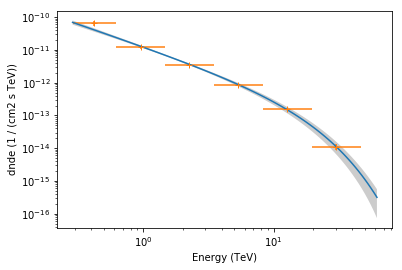

In [49]:
# Let's plot the spectrum
source.spectral_model().plot(source.energy_range)
source.spectral_model().plot_error(source.energy_range)
source.flux_points.plot()

Text(0.5,1,'Vela X HGPS spectrum')

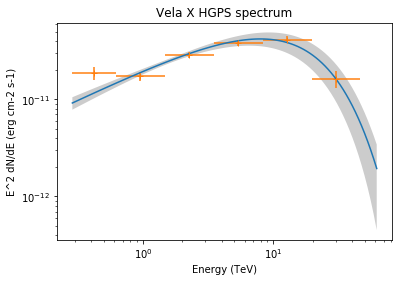

In [50]:
# Or let's make the same plot in the common
# format with y = E^2 * dnde
opts = dict(energy_power=2, flux_unit='erg-1 cm-2 s-1')
source.spectral_model().plot(source.energy_range, **opts)
source.spectral_model().plot_error(source.energy_range, **opts)
source.flux_points.plot(**opts)
plt.ylabel('E^2 dN/dE (erg cm-2 s-1)')
plt.title('Vela X HGPS spectrum')

In the next section we will see how to work with the HGPS survey maps from Gammapy, as well as work with other data from the catalog (position and morphology information).

## Maps with Gammapy

Let's use the [SkyImage](http://docs.gammapy.org/dev/api/gammapy.image.SkyImage.html) class to load up the HGPS significance survey map.

In [51]:
path = hgps_data_path / 'hgps_map_significance_0.1deg_v1.fits.gz'
survey_map = SkyImage.read(path)

(<Figure size 432x288 with 1 Axes>,
 None)

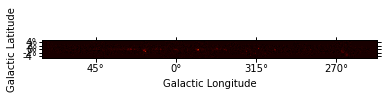

In [52]:
# SkyImage has a quick-look plot method, but it's not
# very useful for a survey map that wide with default settings  
survey_map.plot()

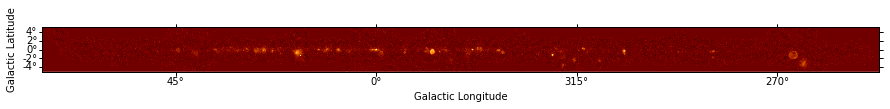

In [53]:
# This is a little better
fig = plt.figure(figsize=(15,3))
_ = survey_map.plot(stretch='sqrt')
# Note that we also assign the return value (a tuple)
# from the plot method call to a variable called `_`
# This is to avoid Jupyter printing it like in the last cell,
# and generally `_` is a variable name used in Python
# for things you don't want to name or care about at all

Let's look at a cutout of the Galactic center:

[None, None]

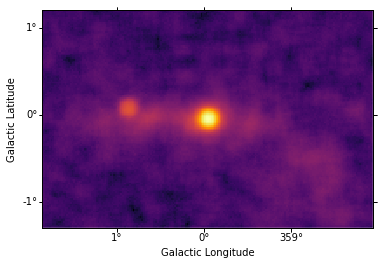

In [54]:
image = survey_map.cutout(pos, size=(2.5, 3.8)*u.deg)
fig, ax, _ = image.plot(stretch='sqrt', cmap='inferno')
[ax.coords[_].set_major_formatter('dd') for _ in (0, 1)]

Side comment: If you like, you can format stuff to make it a bit more pretty. With a few lines you can get nice plots, with a few dozen publication-quality images. This is using [matplotlib](https://matplotlib.org/) and [astropy.visualization](http://docs.astropy.org/en/stable/visualization/index.html). Both are pretty complex, but there's many examples available and there's not really another good alternative anyways for astronomical sky images at the moment, so you should just go ahead and learn those.

There's also a convenience method to look up the map value at a given sky position.
Let's repeat this for the same position we did above with Numpy and Astropy:

In [55]:
pos = SkyCoord(266.416826, -29.007797, unit='deg')
survey_map.lookup(pos)

89.49691

### Vela X

To finish up this tutorial, let's do something a bit more advanced, than involves the survey map, the HGPS source catalog, the multi-Gauss morphology component model. Let's show the Vela X pulsar wind nebula and the Vela Junior supernova remnant, and overplot some HGPS catalog data.

In [56]:
# The spatial model for Vela X in HGPS was three Gaussians
print(source.name)
for component in source.components:
    print(component)

HESS J0835-455
Component HGPSC 001:
GLON                 :  263.969 +/- 0.023 deg
GLAT                 :   -3.344 +/- 0.027 deg
Size                 : 0.237 +/- 0.023 deg
Flux (>1 TeV)        : (2.76 +/- 0.52) x 10^-12 cm^-2 s^-1 = (12.2 +/- 2.3) % Crab
Component HGPSC 002:
GLON                 :  263.699 +/- 0.021 deg
GLAT                 :   -2.827 +/- 0.037 deg
Size                 : 0.156 +/- 0.018 deg
Flux (>1 TeV)        : (1.08 +/- 0.21) x 10^-12 cm^-2 s^-1 = (4.8 +/- 0.9) % Crab
Component HGPSC 003:
GLON                 :  263.983 +/- 0.033 deg
GLAT                 :   -2.997 +/- 0.046 deg
Size                 : 0.650 +/- 0.027 deg
Flux (>1 TeV)        : (11.52 +/- 0.73) x 10^-12 cm^-2 s^-1 = (51.0 +/- 3.2) % Crab


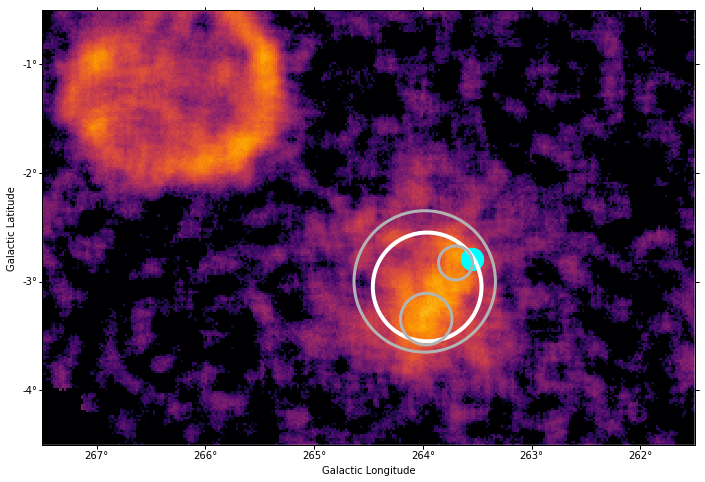

In [57]:
from astropy.visualization import simple_norm
from matplotlib.patches import Circle

# Cutout and plot a nice image
pos = SkyCoord(264.5, -2.5, unit='deg', frame='galactic')
size = (4, 6)*u.deg
image = survey_map.cutout(pos, size=size)
norm = simple_norm(image.data, stretch='sqrt', min_cut=0, max_cut=20)
fig = plt.figure(figsize=(12, 8))
fig, ax, _ = image.plot(fig=fig, norm=norm, cmap='inferno')
transform = ax.get_transform('galactic')

# Overplot the pulsar
# print(SkyCoord.from_name('Vela pulsar').galactic)
ax.scatter(263.551, -2.787, transform=transform, s=500, color='cyan')

# Overplot the circle that was used for the HGPS spectral measurement of Vela X
# It is centered on the centroid of the emission and has a radius of 0.5 deg
x = source.data['GLON'].value
y = source.data['GLAT'].value
r = source.data['RSpec'].value
c = Circle((x, y), r, transform=transform, edgecolor='white', facecolor='none', lw=4)
ax.add_patch(c)

# Overplot circles that represent the components
for c in source.components:
    x = c.data['GLON'].value
    y = c.data['GLAT'].value
    r = c.data['Size'].value
    c = Circle((x, y), r, transform=transform, edgecolor='0.7', facecolor='none', lw=3)
    ax.add_patch(c)

We note that for HGPS there are already spatial models available:

    print(source.spatial_model())
    source.components[0].spatial_model

With some effort, you can use those to make HGPS model flux images.

There are two reasons we're not showing this here: First, the spatial model code in Gammapy is work in progress, it will change soon. Secondly, doing morphology measurements on the public HGPS maps is discouraged; we note again that the maps are correlated and no detailed PSF information is published. So please be careful / conservative when extracting quantitative mesurements from the HGPS maps e.g. for a source of interest for you.

## Conclusions

This concludes this tutorial how to access and work with the HGPS data from Python, using Astropy and Gammapy.


* If you have any questions about the HGPS data, please use the contact given at https://www.mpi-hd.mpg.de/hfm/HESS/hgps/ .
* If you have any questions or issues about Astropy or Gammapy, please use the Gammapy mailing list (see http://gammapy.org/contact.html).

**Please read the Appendix A of the paper to learn about the caveats to using the HGPS data. Especially note that the HGPS survey maps are correlated and thus no detailed source morphology analysis is possible, and also note the caveats concerning spectral models and spectral flux points.**

## Exercises

* Re-run this notebook, but change the HGPS source that was used for examples. If you have any questions about the data, try to access and print or plot it. Just to give a few ideas: How many identified pulsar wind nebulae are in HGPS? Which are the 5 brightest HGPS sources in the 1-10 TeV energy band? Which is the second-highest significance source in the HPGS image after the Galactic center?
* Try to reproduce some of the figures in the HGPS paper. Don't try to reproduce them exactly, but just try to write ~ 10 lines of code to access the relevant HGPS data and make a quick plot that shows the same or similar information.
* Fit a spectral model to the spectral points of Vela X and compare with the HGPS model fit. (they should be similar, but not identical, in HGPS a likelihood fit to counts data was done). For this task, the [spectrum_models](http://docs.gammapy.org/dev/notebooks/spectrum_models.html) and [sed_fitting_gammacat_fermi](http://docs.gammapy.org/dev/notebooks/sed_fitting_gammacat_fermi.html) tutorials will be useful.
